In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('data/data.csv')

In [3]:
for col in df.columns:
    print(col, type(col))

Unnamed: 0 <class 'str'>
employee_id <class 'str'>
entitlement_id <class 'str'>
grant_date <class 'str'>
entitlement_name <class 'str'>
application_id <class 'str'>
type <class 'str'>
entitlement_description <class 'str'>
risk_level <class 'str'>
function <class 'str'>
department_id <class 'str'>
manager_id <class 'str'>
name_department <class 'str'>
parent_id <class 'str'>
name <class 'str'>
app_description <class 'str'>
criticality <class 'str'>


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import json
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class AutoEncoder(nn.Module):
    """
    Autoencoder for anomaly detection in assignment patterns
    """
    def __init__(self, input_dim, hidden_dims=[64, 32, 16]):
        super(AutoEncoder, self).__init__()

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        hidden_dims_reversed = hidden_dims[::-1][1:] + [input_dim]
        for hidden_dim in hidden_dims_reversed:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU() if hidden_dim != input_dim else nn.Sigmoid()
            ])
            prev_dim = hidden_dim

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

class VariationalAutoEncoder(nn.Module):
    """
    Variational Autoencoder for more sophisticated anomaly detection
    """
    def __init__(self, input_dim, latent_dim=10, hidden_dims=[64, 32]):
        super(VariationalAutoEncoder, self).__init__()

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        self.encoder = nn.Sequential(*encoder_layers)
        self.fc_mu = nn.Linear(prev_dim, latent_dim)
        self.fc_var = nn.Linear(prev_dim, latent_dim)

        # Decoder
        decoder_layers = [nn.Linear(latent_dim, hidden_dims[-1]), nn.ReLU()]
        prev_dim = hidden_dims[-1]
        for hidden_dim in hidden_dims[::-1][1:]:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        decoder_layers.extend([
            nn.Linear(prev_dim, input_dim),
            nn.Sigmoid()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def preprocess_assignment_data(df):
    """
    Preprocess data for toxic assignment detection
    """
    df_processed = df.copy()

    # Drop unnamed column
    if 'Unnamed: 0' in df_processed.columns:
        df_processed = df_processed.drop('Unnamed: 0', axis=1)

    # Process grant_date
    if 'grant_date' in df_processed.columns:
        df_processed['grant_date'] = pd.to_datetime(df_processed['grant_date'], errors='coerce')
        df_processed['grant_month'] = df_processed['grant_date'].dt.month
        df_processed['grant_year'] = df_processed['grant_date'].dt.year
        df_processed['grant_quarter'] = df_processed['grant_date'].dt.quarter
        df_processed = df_processed.drop('grant_date', axis=1)

    # Convert numerical columns
    for col in ['risk_level', 'criticality']:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

    # Handle missing values
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_processed[col].fillna('Unknown', inplace=True)

    return df_processed

def create_assignment_features(df):
    """
    Create features that capture assignment patterns and combinations
    """
    features_df = df.copy()

    # Employee-level aggregations (safer approach)
    employee_agg = []

    for emp_id, group in df.groupby('employee_id'):
        emp_features = {
            'employee_id': emp_id,
            'risk_level_mean': group['risk_level'].mean(),
            'risk_level_max': group['risk_level'].max(),
            'risk_level_std': group['risk_level'].std(),
            'risk_level_count': group['risk_level'].count(),
            'criticality_mean': group['criticality'].mean(),
            'criticality_max': group['criticality'].max(),
            'criticality_std': group['criticality'].std(),
            'application_id_nunique': group['application_id'].nunique(),
            'entitlement_id_nunique': group['entitlement_id'].nunique(),
            'department_id_nunique': group['department_id'].nunique(),
            'type_nunique': group['type'].nunique(),
            'most_common_type': group['type'].mode().iloc[0] if len(group['type'].mode()) > 0 else 'Unknown'
        }
        employee_agg.append(emp_features)

    employee_features = pd.DataFrame(employee_agg)

    # Application-level features
    app_risk = df.groupby('application_id').agg({
        'risk_level': 'mean',
        'criticality': 'mean',
        'employee_id': 'nunique'
    }).reset_index()
    app_risk.columns = ['application_id', 'app_avg_risk', 'app_avg_criticality', 'app_user_count']

    # Department-level features
    dept_risk = df.groupby('department_id').agg({
        'risk_level': 'mean',
        'criticality': 'mean',
        'employee_id': 'nunique'
    }).reset_index()
    dept_risk.columns = ['department_id', 'dept_avg_risk', 'dept_avg_criticality', 'dept_user_count']

    # Merge features back
    features_df = features_df.merge(employee_features, on='employee_id', how='left')
    features_df = features_df.merge(app_risk, on='application_id', how='left')
    features_df = features_df.merge(dept_risk, on='department_id', how='left')

    return features_df

def encode_categorical_features(df):
    """
    Encode categorical features for neural network training
    """
    df_encoded = df.copy()
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns

    # Use label encoding for high cardinality and one-hot for low cardinality
    encoders = {}

    for col in categorical_cols:
        unique_values = df_encoded[col].nunique()

        if unique_values > 20:  # High cardinality - use label encoding
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            encoders[col] = le
        else:  # Low cardinality - use one-hot encoding
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded.drop(col, axis=1), dummies], axis=1)

    return df_encoded, encoders

def train_autoencoder(X_train, input_dim, epochs=100, batch_size=32, lr=0.001,
                     checkpoint_dir='checkpoints', patience=10, min_delta=1e-4):
    """
    Train autoencoder for anomaly detection with early stopping and checkpointing

    Args:
        X_train: Training data
        input_dim: Input dimension
        epochs: Maximum number of epochs
        batch_size: Batch size
        lr: Learning rate
        checkpoint_dir: Directory to save checkpoints
        patience: Number of epochs to wait before early stopping
        min_delta: Minimum change in loss to be considered improvement
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Initialize or load model
    model = AutoEncoder(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Check for existing checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
    training_state_path = os.path.join(checkpoint_dir, 'training_state.json')

    start_epoch = 0
    best_loss = float('inf')
    patience_counter = 0
    losses = []

    # Load checkpoint if exists
    if os.path.exists(checkpoint_path) and os.path.exists(training_state_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        with open(training_state_path, 'r') as f:
            training_state = json.load(f)

        start_epoch = training_state['epoch'] + 1
        best_loss = training_state['best_loss']
        patience_counter = training_state['patience_counter']
        losses = training_state['losses']

        print(f"Resuming from epoch {start_epoch} with best loss {best_loss:.6f}")

    # Create data loader
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor, X_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop with early stopping
    model.train()

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0
        for batch_data, _ in dataloader:
            optimizer.zero_grad()

            # Forward pass
            reconstructed = model(batch_data)
            loss = criterion(reconstructed, batch_data)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        # Print progress
        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}, Best Loss: {best_loss:.6f}')

        # Early stopping check
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            patience_counter = 0

            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }
            torch.save(checkpoint, checkpoint_path)

            # Save training state
            training_state = {
                'epoch': epoch,
                'best_loss': best_loss,
                'patience_counter': patience_counter,
                'losses': losses
            }
            with open(training_state_path, 'w') as f:
                json.dump(training_state, f)

            print(f"Saved checkpoint at epoch {epoch} with loss {best_loss:.6f}")
        else:
            patience_counter += 1

            # Save current state even if not best (for resuming)
            training_state = {
                'epoch': epoch,
                'best_loss': best_loss,
                'patience_counter': patience_counter,
                'losses': losses
            }
            with open(training_state_path, 'w') as f:
                json.dump(training_state, f)

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best loss: {best_loss:.6f}")
            break

    # Load best model
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded best model")

    return model, losses

def detect_anomalies(model, X_data, threshold_percentile=95):
    """
    Detect anomalies using reconstruction error
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    X_tensor = torch.FloatTensor(X_data).to(device)

    with torch.no_grad():
        reconstructed = model(X_tensor)
        reconstruction_errors = torch.mean((X_tensor - reconstructed) ** 2, dim=1)
        reconstruction_errors = reconstruction_errors.cpu().numpy()

    # Define threshold
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    anomalies = reconstruction_errors > threshold

    return anomalies, reconstruction_errors, threshold

def analyze_toxic_combinations(df, anomaly_indices):
    """
    Analyze the toxic combinations detected
    """
    toxic_assignments = df.iloc[anomaly_indices].copy()

    print(f"Detected {len(toxic_assignments)} potentially toxic assignments")
    print(f"Percentage of total assignments: {len(toxic_assignments)/len(df)*100:.2f}%")

    # Analyze patterns in toxic assignments
    print("\n=== TOXIC ASSIGNMENT PATTERNS ===")

    # Risk level distribution
    print("\nRisk Level Distribution in Toxic Assignments:")
    print(toxic_assignments['risk_level'].value_counts().sort_index())

    # Criticality distribution
    print("\nCriticality Distribution in Toxic Assignments:")
    print(toxic_assignments['criticality'].value_counts().sort_index())

    # Most common toxic combinations
    print("\nMost Common Application Types in Toxic Assignments:")
    print(toxic_assignments['type'].value_counts().head(10))

    print("\nMost Common Applications in Toxic Assignments:")
    print(toxic_assignments['entitlement_name'].value_counts().head(10))

    # Employee analysis
    toxic_employees = toxic_assignments['employee_id'].value_counts()
    print(f"\nEmployees with multiple toxic assignments:")
    print(toxic_employees[toxic_employees > 1].head(10))

    return toxic_assignments

def save_pipeline_state(pipeline_results, save_dir='pipeline_state'):
    """
    Save the entire pipeline state for later use
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save model is already handled in training

    # Save scaler
    import joblib
    joblib.dump(pipeline_results['scaler'], os.path.join(save_dir, 'scaler.pkl'))

    # Save encoders
    joblib.dump(pipeline_results['encoders'], os.path.join(save_dir, 'encoders.pkl'))

    # Save metadata
    metadata = {
        'threshold': float(pipeline_results['threshold']),
        'feature_names': pipeline_results['feature_names'],
        'anomaly_count': len(pipeline_results['anomaly_indices']),
        'total_samples': len(pipeline_results['reconstruction_errors'])
    }

    with open(os.path.join(save_dir, 'metadata.json'), 'w') as f:
        json.dump(metadata, f)

    # Save toxic assignments
    pipeline_results['toxic_assignments'].to_csv(
        os.path.join(save_dir, 'toxic_assignments.csv'),
        index=False
    )

    print(f"Pipeline state saved to {save_dir}")

def load_pipeline_state(save_dir='pipeline_state', checkpoint_dir='checkpoints'):
    """
    Load a saved pipeline state
    """
    import joblib

    # Load metadata
    with open(os.path.join(save_dir, 'metadata.json'), 'r') as f:
        metadata = json.load(f)

    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')

    input_dim = len(metadata['feature_names'])
    model = AutoEncoder(input_dim).to(device)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Load scaler and encoders
    scaler = joblib.load(os.path.join(save_dir, 'scaler.pkl'))
    encoders = joblib.load(os.path.join(save_dir, 'encoders.pkl'))

    return {
        'model': model,
        'scaler': scaler,
        'encoders': encoders,
        'threshold': metadata['threshold'],
        'feature_names': metadata['feature_names']
    }

def run_toxic_detection_pipeline(df, checkpoint_dir='checkpoints', save_state=True):
    """
    Complete pipeline for detecting toxic assignment combinations with checkpointing
    """
    print("Starting toxic assignment detection pipeline...")
    print(f"Original DataFrame shape: {df.shape}")

    # Step 1: Preprocess data
    df_processed = preprocess_assignment_data(df)
    print(f"After preprocessing shape: {df_processed.shape}")

    # Step 2: Create assignment pattern features
    df_features = create_assignment_features(df_processed)
    print(f"After feature engineering shape: {df_features.shape}")

    # Step 3: Encode categorical features
    df_encoded, encoders = encode_categorical_features(df_features)

    # Step 4: Prepare data for neural network
    # Remove ID columns for training
    id_cols = ['employee_id', 'entitlement_id', 'application_id', 'manager_id', 'parent_id', 'department_id']
    X_features = df_encoded.drop([col for col in id_cols if col in df_encoded.columns], axis=1)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    print(f"Features for training shape: {X_scaled.shape}")

    # Step 5: Train autoencoder with early stopping and checkpointing
    print("\nTraining autoencoder with early stopping...")
    model, losses = train_autoencoder(
        X_scaled,
        X_scaled.shape[1],
        checkpoint_dir=checkpoint_dir,
        patience=10,  # Stop if no improvement for 10 epochs
        min_delta=1e-4  # Minimum improvement threshold
    )

    # Step 6: Detect anomalies
    print("\nDetecting anomalies...")
    anomalies, reconstruction_errors, threshold = detect_anomalies(model, X_scaled)

    # Step 7: Analyze results
    toxic_assignments = analyze_toxic_combinations(df_processed, np.where(anomalies)[0])

    # Additional analysis with traditional methods for comparison
    print("\n=== COMPARISON WITH TRADITIONAL METHODS ===")

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_anomalies = iso_forest.fit_predict(X_scaled) == -1
    print(f"Isolation Forest detected {np.sum(iso_anomalies)} anomalies")

    # DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(X_scaled)
    dbscan_anomalies = clusters == -1
    print(f"DBSCAN detected {np.sum(dbscan_anomalies)} outliers")

    results = {
        'model': model,
        'scaler': scaler,
        'encoders': encoders,
        'toxic_assignments': toxic_assignments,
        'reconstruction_errors': reconstruction_errors,
        'threshold': threshold,
        'anomaly_indices': np.where(anomalies)[0],
        'feature_names': X_features.columns.tolist()
    }

    # Save pipeline state if requested
    if save_state:
        save_pipeline_state(results)

    return results

def visualize_results(results):
    """
    Visualize the anomaly detection results
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: Reconstruction error distribution
    plt.subplot(2, 3, 1)
    plt.hist(results['reconstruction_errors'], bins=50, alpha=0.7)
    plt.axvline(results['threshold'], color='red', linestyle='--', label=f'Threshold: {results["threshold"]:.4f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()

    # Plot 2: Risk level vs Criticality for toxic assignments
    plt.subplot(2, 3, 2)
    toxic = results['toxic_assignments']
    plt.scatter(toxic['risk_level'], toxic['criticality'], alpha=0.6, color='red', label='Toxic')
    plt.xlabel('Risk Level')
    plt.ylabel('Criticality')
    plt.title('Risk vs Criticality (Toxic Assignments)')
    plt.legend()

    # Plot 3: Top toxic application types
    plt.subplot(2, 3, 3)
    top_types = toxic['type'].value_counts().head(10)
    plt.barh(range(len(top_types)), top_types.values)
    plt.yticks(range(len(top_types)), top_types.index)
    plt.xlabel('Count')
    plt.title('Top Toxic Application Types')

    plt.tight_layout()
    plt.show()

# Example usage
"""
# Load your data
df = pd.read_csv('your_assignment_data.csv')

# Run the toxic detection pipeline (will resume from checkpoint if interrupted)
results = run_toxic_detection_pipeline(df, checkpoint_dir='checkpoints', save_state=True)

# Visualize results
visualize_results(results)

# Get the toxic assignments for further investigation
toxic_assignments = results['toxic_assignments']

# Save toxic assignments for review
toxic_assignments.to_csv('toxic_assignments_detected.csv', index=False)

# To load a saved pipeline for inference on new data:
saved_pipeline = load_pipeline_state('pipeline_state', 'checkpoints')
"""

print("Enhanced toxic assignment detection pipeline ready!")
print("Features added:")
print("- Early stopping when loss stops improving")
print("- Automatic checkpointing for resumable training")
print("- Pipeline state saving and loading")
print("\nUse run_toxic_detection_pipeline(df) to detect toxic combinations")

Enhanced toxic assignment detection pipeline ready!
Features added:
- Early stopping when loss stops improving
- Automatic checkpointing for resumable training
- Pipeline state saving and loading

Use run_toxic_detection_pipeline(df) to detect toxic combinations


In [7]:
results=run_toxic_detection_pipeline(df)

Starting toxic assignment detection pipeline...
Original DataFrame shape: (512716, 17)
After preprocessing shape: (512716, 18)
After feature engineering shape: (512716, 36)
Features for training shape: (512716, 63)

Training autoencoder with early stopping...
Loading checkpoint...
Resuming from epoch 57 with best loss 0.678732
Early stopping triggered at epoch 57. Best loss: 0.678732
Loaded best model

Detecting anomalies...
Detected 25636 potentially toxic assignments
Percentage of total assignments: 5.00%

=== TOXIC ASSIGNMENT PATTERNS ===

Risk Level Distribution in Toxic Assignments:
risk_level
3    2320
4    4988
5    4100
6    7204
7    2540
8    4484
Name: count, dtype: int64

Criticality Distribution in Toxic Assignments:
criticality
4    4945
5    2670
6     708
7    5144
8    5633
9    6536
Name: count, dtype: int64

Most Common Application Types in Toxic Assignments:
type
read       11393
write       5217
execute     4749
admin       4277
Name: count, dtype: int64

Most Comm

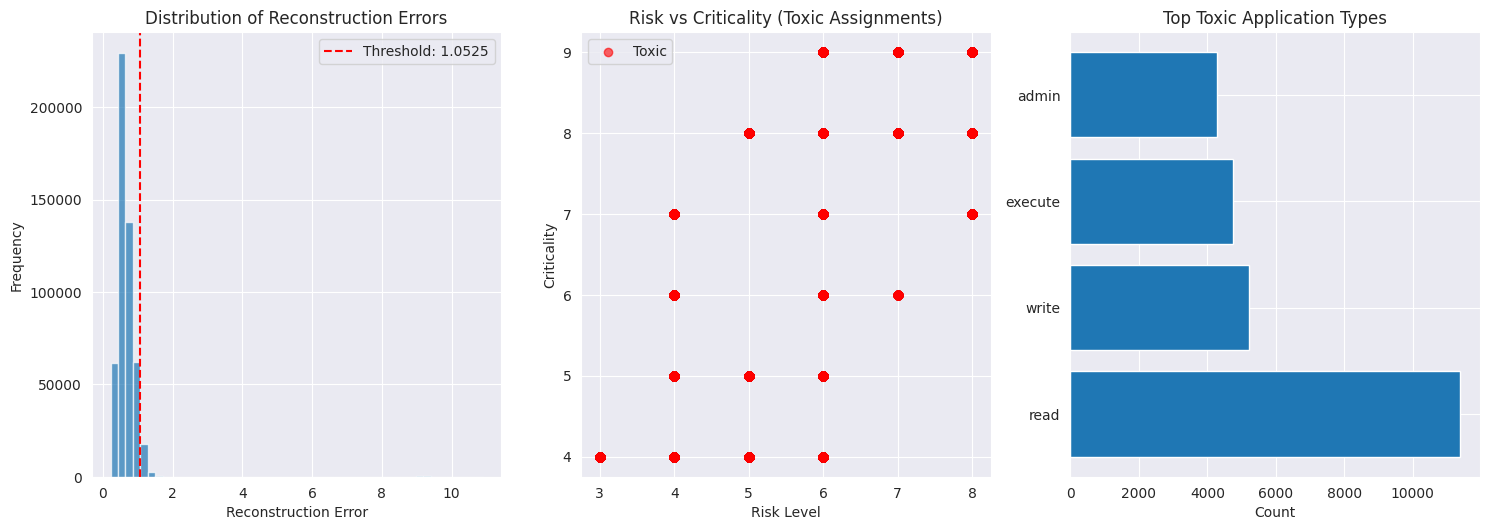

In [8]:
visualize_results(results)